In [1]:
import imageio
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [2]:
K.clear_session()

def cnn_model(img, cb_img):
    
    conv_1 = Conv2D(16, (7, 7), activation='relu', padding='same', strides=1)(img)
    conv_1 = Conv2D(32, (5, 5), activation='relu', padding='same', strides=1)(conv_1)
    conv_1 = Conv2D(64, (3, 3), activation='relu', padding='same', strides=1)(conv_1)

    conv_2 = Conv2D(16, (7, 7), activation='relu', padding='same', strides=1)(cb_img)
    conv_2 = Conv2D(32, (5, 5), activation='relu', padding='same', strides=1)(conv_2)
    conv_2 = Conv2D(64, (3, 3), activation='relu', padding='same', strides=1)(conv_2)

    add_1 = tf.keras.layers.Add()([conv_1, conv_2])

    conv_4 = Conv2D(16, (7, 7), activation='relu', padding='same', strides=1)(add_1)
    conv_5 = Conv2D(16, (3, 3), activation='relu', padding='same', strides=1)(conv_4)

    add_2 = tf.keras.layers.Add()([conv_4, conv_5])

    conv_6 = Conv2D(16, (3, 3), activation='relu', padding='same', strides=1)(add_2)
    conv_6 = Conv2D(3, (3, 3), activation='relu', padding='same', strides=1)(conv_6)

    return conv_6


In [5]:
d_path = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/train-set/raw'
cb_d_path = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/train-set/cb_raw'
t_path = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/train-set/reference'

data = []
cb_data = []
target = []

im_h = 112
im_w = 112
for imagePath in os.listdir(d_path):

    # get full the path of the raw(real), cb_raw(color balancing real) and reference(target) images
    data_path = os.path.join(d_path, imagePath)
    cb_data_path = os.path.join(cb_d_path, imagePath)
    target_path = os.path.join(t_path, imagePath)
    
    #read the images
    img = cv2.imread(data_path)
    cb_img = cv2.imread(cb_data_path)
    target_img = cv2.imread(target_path)

    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    # cb_img = cv2.cvtColor(cb_img, cv2.COLOR_BGR2RGB)

    #resize the images into 112 x 112
    img = cv2.resize(img, (im_h, im_w))
    cb_img = cv2.resize(cb_img, (im_h, im_w))
    target_img = cv2.resize(target_img, (im_h, im_w))
        
    # put the images into array list
    data.append(img)
    cb_data.append(cb_img)
    target.append(target_img)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# convert arrays into numpy arrays
data = np.array(data)
cb_data = np.array(cb_data)
target = np.array(target)

print(data.shape, cb_data.shape, target.shape)

(712, 112, 112, 3) (712, 112, 112, 3) (712, 112, 112, 3)


In [7]:
%cd '/content/drive/MyDrive/UnderwaterImageEnhancement/models/npfile-model2/'

# save the numpy arrays
np.save('data', data)
np.save('cb_data', cb_data)
np.save('target', target)

/content/drive/MyDrive/UnderwaterImageEnhancement/models/npfile-model2


In [8]:
%cd '/content/drive/MyDrive/UnderwaterImageEnhancement/models/npfile-model2/'

# load the numpy arrays
data = np.load('data.npy')
cb_data = np.load('cb_data.npy')
target = np.load('target.npy')

print(data.shape, cb_data.shape, target.shape)

/content/drive/MyDrive/UnderwaterImageEnhancement/models/npfile-model2
(712, 112, 112, 3) (712, 112, 112, 3) (712, 112, 112, 3)


In [9]:
im_h = 112
im_w = 112

# initiate keras tensor input_sample, input_cb_sample, and output_
input_sample = Input(shape=(im_h, im_w, 3))
input_cb_sample = Input(shape=(im_h, im_w, 3))
output_ = cnn_model(input_sample, input_cb_sample)

# create the model in function way by specfying input and output
model_enhancer = Model(inputs=[input_sample, input_cb_sample], outputs=output_)

# Configures the model for training with loss function and optimizer
model_enhancer.compile(loss='mse', optimizer='adam', metrics=['mse', 'accuracy'])
model_enhancer.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 16) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 112, 112, 16) 2368        input_2[0][0]                    
______________________________________________________________________________________________

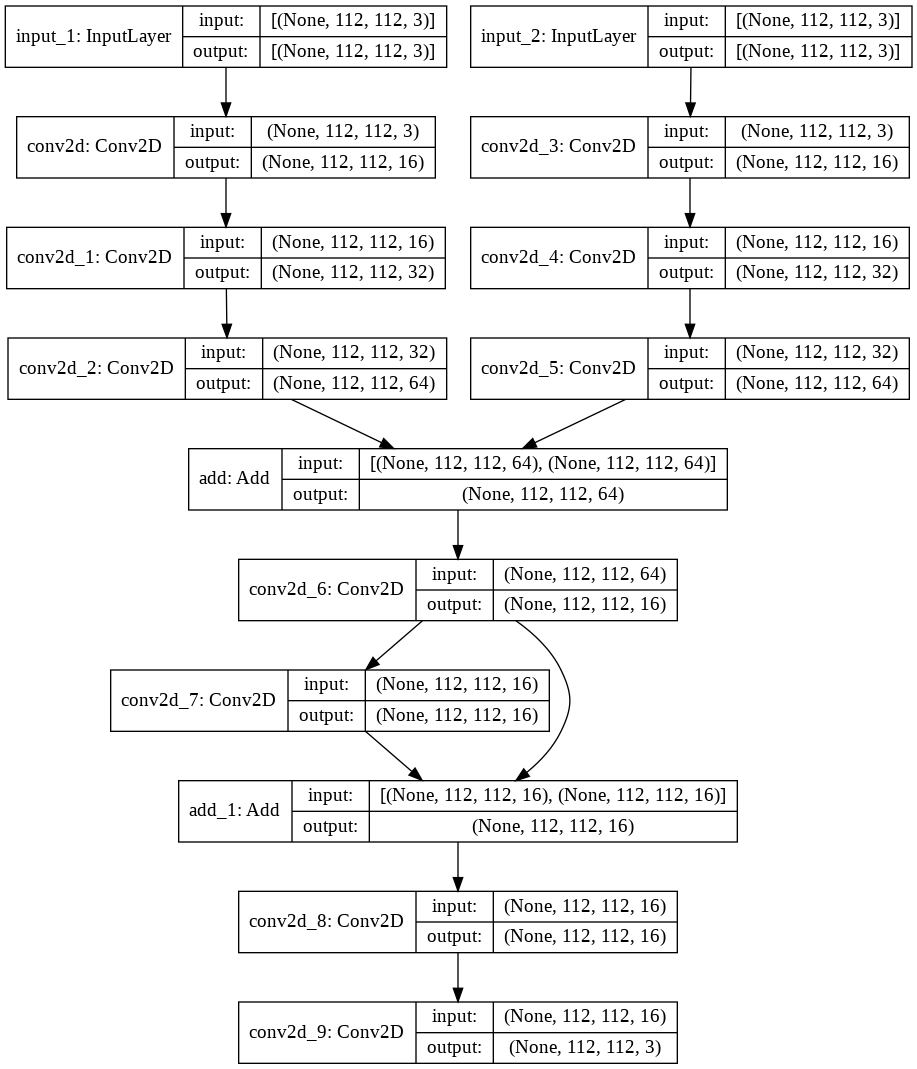

In [10]:
plot_model(model_enhancer, to_file='/content/drive/MyDrive/UnderwaterImageEnhancement/models/model2_view.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='/content/drive/MyDrive/UnderwaterImageEnhancement/models/model2_view.png')

In [11]:
# split training dataset into 80% for training and 20% for validation
train_data, val_data, train_cb_data, val_cb_data, train_target, val_target = train_test_split(data,
                                                                                              cb_data,
                                                                                              target,
                                                                                              test_size=0.2)

print(len(train_data), len(train_cb_data), len(train_target), len(val_data), len(val_cb_data), len(val_target))

569 569 569 143 143 143


In [12]:
epoch = 100

#
checkpoint = ModelCheckpoint('/content/drive/MyDrive/UnderwaterImageEnhancement/checkpoints/model2/model-{epoch:03d}.h5', monitor="val_loss", save_best_only=False, mode='auto', save_freq=epoch)

# train the model
history = model_enhancer.fit([train_data, train_cb_data], train_target, validation_data=([val_data, val_cb_data], val_target), batch_size=16, epochs=epoch, callbacks=[checkpoint])



Epoch 1/100
36/36 [==============================] - 37s 170ms/step - loss: 3516.1768 - mse: 3516.1770 - accuracy: 0.4118 - val_loss: 1855.6104 - val_mse: 1855.6102 - val_accuracy: 0.4849
Epoch 2/100
36/36 [==============================] - 4s 119ms/step - loss: 1500.9961 - mse: 1500.9960 - accuracy: 0.5443 - val_loss: 1158.8265 - val_mse: 1158.8265 - val_accuracy: 0.6333
Epoch 3/100
28/36 [======================>.......] - ETA: 0s - loss: 1232.6991 - mse: 1232.6993 - accuracy: 0.6193

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


36/36 [==============================] - 5s 137ms/step - loss: 1225.2262 - mse: 1225.2263 - accuracy: 0.6218 - val_loss: 1095.4301 - val_mse: 1095.4301 - val_accuracy: 0.6370
Epoch 4/100
36/36 [==============================] - 4s 118ms/step - loss: 1115.8186 - mse: 1115.8185 - accuracy: 0.6383 - val_loss: 1093.4089 - val_mse: 1093.4091 - val_accuracy: 0.6335
Epoch 5/100
36/36 [==============================] - 4s 119ms/step - loss: 1109.8925 - mse: 1109.8925 - accuracy: 0.6289 - val_loss: 929.2990 - val_mse: 929.2989 - val_accuracy: 0.6807
Epoch 6/100
36/36 [==============================] - 4s 121ms/step - loss: 1042.2128 - mse: 1042.2128 - accuracy: 0.6573 - val_loss: 1021.2659 - val_mse: 1021.2659 - val_accuracy: 0.6907
Epoch 7/100
36/36 [==============================] - 4s 119ms/step - loss: 1148.9166 - mse: 1148.9166 - accuracy: 0.6382 - val_loss: 1201.5763 - val_mse: 1201.5762 - val_accuracy: 0.6859
Epoch 8/100
36/36 [==============================] - 4s 119ms/step - loss: 1040

In [13]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'mse', 'accuracy', 'val_loss', 'val_mse', 'val_accuracy'])


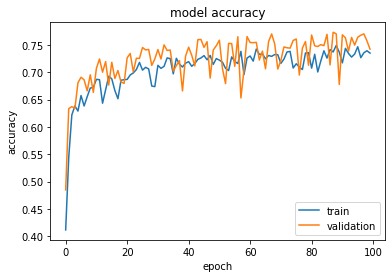

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

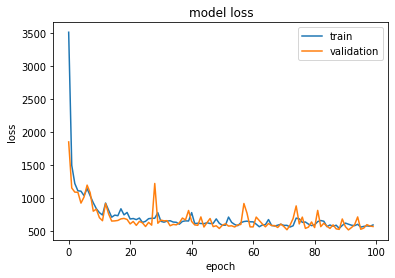

In [15]:
# summarize history for loss
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [16]:
# Evaluate the model on the test data
val_loss, val_mse, val_accuracy = model_enhancer.evaluate([val_data, val_cb_data], val_target, verbose=2)

print("validation loss", val_loss)
print("MSE for validation:", val_mse)
print("validation accuracy:", val_accuracy)

5/5 - 2s - loss: 574.4550 - mse: 574.4549 - accuracy: 0.7420
validation loss 574.4549560546875
MSE for validation: 574.4548950195312
validation accuracy: 0.7420453429222107


In [17]:
import numpy as np
from PIL import Image
import cv2
import os
from matplotlib import pyplot as plt


test_path = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/test-set/raw/'
cb_test_path = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/test-set/cb_raw'
destination = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/test-set/model2-output/'

im_h = 112
im_w = 112
for test_img_name in os.listdir(test_path):

    #read the raw images
    test_img = cv2.imread(os.path.join(test_path, test_img_name))
    cb_test_img = cv2.imread(os.path.join(cb_test_path, test_img_name))
   
    #resize the images into 480 x 480
    test_img = cv2.resize(test_img, (im_h, im_w))
    cb_test_img = cv2.resize(cb_test_img, (im_h, im_w))
    
    # reshape the image (480, 480, 3) into (1, 480, 480, 3)
    test_img = test_img.reshape(1,im_h, im_w,3)
    cb_test_img = cb_test_img.reshape(1,im_h, im_w,3)

    # use model to do prediction
    result = model_enhancer.predict([test_img, cb_test_img])
    #
    result = result.squeeze()
    
    test_img = test_img.squeeze()
    
    test_img[:,:,:] = result[:,:,:]
    #plt.imshow(test_img)
    cv2.imwrite(os.path.join(destination, test_img_name), test_img)



In [18]:
import numpy as np
import cv2
import os

from sklearn.metrics import mean_squared_error

target_path = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/test-set/reference'
predicted_path = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/test-set/model2-output/'

target_data = []
predict_data = []


im_h = 112
im_w = 112
for image_name in os.listdir(target_path):

    #read the raw images
    target_img = cv2.imread(os.path.join(target_path, image_name))
    predicted_img = cv2.imread(os.path.join(predicted_path, image_name))
    

    #resize the images into 112 x 112
    target_img = cv2.resize(target_img, (im_h, im_w))
    predicted_img = cv2.resize(predicted_img, (im_h, im_w))
        
    # put the images into array list
    target_data.append(target_img)
    predict_data.append(predicted_img)


# convert arrays into numpy arrays
target_data = np.array(target_data)
predict_data = np.array(predict_data)

print(target_data.shape, predict_data.shape)


%cd '/content/drive/MyDrive/UnderwaterImageEnhancement/models/npfile-model2/'

# save the numpy arrays
np.save('target_data', target_data)
np.save('predict_data', predict_data)



(178, 112, 112, 3) (178, 112, 112, 3)
/content/drive/MyDrive/UnderwaterImageEnhancement/models/npfile-model2


In [19]:
%cd '/content/drive/MyDrive/UnderwaterImageEnhancement/models/npfile-model2/'

# load the numpy arrays
target_data = np.load('target_data.npy')
predict_data = np.load('predict_data.npy')

print(target_data.shape, predict_data.shape)

/content/drive/MyDrive/UnderwaterImageEnhancement/models/npfile-model2
(178, 112, 112, 3) (178, 112, 112, 3)


In [20]:
###### FULL-REFERENCE IMAGE QUALITY ASSESSMENT IN TERMS OF MSE, PSNR, AND SSIM #######

import numpy as np
  
# Mean Squared Error
MSE = np.square(np.subtract(target_data,predict_data)).mean()
print("MSE for test data :",MSE)

MSE for test data : 83.14280265301345


In [21]:
mse = (np.square(target_data - predict_data)).mean(axis=None)

print("MSE for test data :",mse)

MSE for test data : 83.14280265301345


In [22]:
# PSNR 
from math import log10, sqrt

def PSNR(target_data, predict_data):
 mse = np.mean((target_data - predict_data) ** 2)
 print(mse)
 if(mse == 0):
  return 100
 max_pixel = 255.0
 psnr = 20 * log10(max_pixel / sqrt(mse))
 return psnr 


value = PSNR(target_data, predict_data)
print("\nPeak Signal-to-Noise Ratio (PSNR) value is", value, "dB")

83.14280265301345

Peak Signal-to-Noise Ratio (PSNR) value is 28.932557008586073 dB


In [23]:
#SSIM

from skimage.metrics import structural_similarity as ssim

ssim_value = ssim(target_data, predict_data, multichannel=True)
print("SSIM:", ssim_value)

SSIM: 0.8680641573901626


In [24]:
from skimage.measure import compare_ssim

(score, diff) = compare_ssim(target_data, predict_data, full=True, multichannel=True)
diff = (diff * 255).astype("uint8")
print("SSIM:", score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  This is separate from the ipykernel package so we can avoid doing imports until


SSIM: 0.8680641573901626
